<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/17_autoencoder_light_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание light:**

Для базы Fashion-Mnist:
1. Построить CVAE c помощью глубоких полносвязных (сверточных) нейронных сетей. Добиться хорошего качества генерации изображений. Использовать различные архитектуры энкодера и декодера (количество слоев, фильтров в слоях, размеры ядер, слоев нормализации) для различных наборов гипермапараметров (оптимизатор, размер мини-выборки, количество эпох и т.д.). 
2. Ответить на вопрос: как зависит качество генерируемых изображений от размерности скрытого пространства?
 
**Задание pro:**

Для базы Cats&Dogs (или Cifar-10):
1. Выполните задание light для сверточных нейронных сетей.
2. Ответить на вопрос: как зависит качество генерируемых изображений от размерности скрытого пространства? Привести примеры.


In [0]:
!pip install keras==2.0
!pip install tensorflow==1.0

# Подготовка окружения

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Reshape, Lambda, concatenate, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

from IPython.display import clear_output

from keras.objectives import binary_crossentropy
from keras import backend as K
from keras.utils import to_categorical, plot_model

Using TensorFlow backend.


# Загрузка данных

In [0]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test  = X_test .astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test  = np.reshape(X_test,  (len(X_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]

#Построение модели

## Гиперпараметры и константы

In [0]:
batch_size = 500
dropout_rate = 0.3
start_lr = 0.001

digit_size = 28

epoch_output_interval = 5

## Утилиты

In [0]:
# Добавление к модели Dropout и BatchNormalization
def apply_bn_and_dropout(x):
    return Dropout(dropout_rate)(BatchNormalization()(x))


def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


n = 15 # Картинка с 15x15 цифр


## Структура сети

In [0]:
def create_cvae(latent_dim):
    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        print("Sampling: [%s]" % args)
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, 28*28))
        decoded = K.reshape(decoded, shape=(batch_size, 28*28))
        xent_loss = 28*28*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/28/28

    # Структура входов
    input_img = Input(shape=(28, 28, 1), name = "Original_Image")
    input_lbl = Input(shape=(num_classes,), dtype='float32', name = "Enc_Label")
    input_lbl_d = Input(shape=(num_classes,), dtype='float32', name = "Dec_Label")
    latent = Input(shape=(latent_dim, ), name="Latent")

    # Энкодер
    flatten_img = Flatten()(input_img)

    x = concatenate([flatten_img, input_lbl])
    x = Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    encoder  = Model(inputs = [input_img, input_lbl], outputs = l, name = 'Encoder') 
    z_meaner = Model(inputs = [input_img, input_lbl], outputs = z_mean, name = 'Enc_z_mean')
    z_lvarer = Model(inputs = [input_img, input_lbl], outputs = z_log_var, name = 'Enc_z_log_var')

    # Декодер
    x = concatenate([latent, input_lbl_d])
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)

    decoder = Model(inputs = [latent, input_lbl_d], outputs = decoded, name='Decoder')


    # Объединённая модель
    encoded = encoder([input_img, input_lbl])
    print(encoded.shape)
    cvae = Model(inputs = [input_img, input_lbl, input_lbl_d], 
                 outputs = decoder(inputs = [encoded, input_lbl_d]), 
                 name="CVAE")

    style_transfer = Model([input_img, input_lbl, input_lbl_d], 
                           decoder([z_meaner([input_img, input_lbl]), input_lbl_d]), 
                           name="style_transfer")

    cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)
    
    return cvae, style_transfer

### Визуализация структуры сети

In [46]:
plot_model(encoder, to_file='encoder.png', show_layer_names=False, show_shapes=True)
plot_model(decoder, to_file='decoder.png', show_layer_names=False, show_shapes=True)
plot_model(z_meaner, to_file='z_meaner.png', show_layer_names=False, show_shapes=True)
plot_model(z_lvarer, to_file='z_lvarer.png', show_layer_names=False, show_shapes=True)
plot_model(cvae, to_file='cvae.png', show_layer_names=True, show_shapes=True)#, expand_nested=True)

TypeError: ignored

In [50]:
decoder.summary()

NameError: ignored

In [43]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Original_Image (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 784)          0           Original_Image[0][0]             
__________________________________________________________________________________________________
Enc_Label (InputLayer)          (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 794)          0           flatten_9[0][0]                  
                                                                 Enc_Label[0][0]                  
__________

#Обучение

In [0]:
# Работа автокодировщика будет демонстрироваться на нескольких изображениях из начала датасета
n_compare = 10
imgs = X_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch > 0 and epoch % epoch_output_interval == 0:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных изображений
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])


In [76]:
cvae, transformator = create_cvae(200)

# Коллбэки
model_callbacks=[
    LambdaCallback(on_epoch_end=on_epoch_end)
#     ReduceLROnPlateau(factor=0.1, patience=25)
]

# Запуск обучения

cvae.fit(x = [X_train, y_train_cat, y_train_cat], 
         y = X_train, 
         shuffle = True, 
         epochs = 10,
         batch_size = batch_size,
         validation_data = ([X_test, y_test_cat, y_test_cat], X_test),
#              callbacks = model_callbacks,
         verbose=1)

Sampling: [[<tf.Tensor 'dense_322/BiasAdd:0' shape=(?, 200) dtype=float32>, <tf.Tensor 'dense_323/BiasAdd:0' shape=(?, 200) dtype=float32>]]
Sampling: [[<tf.Tensor 'Encoder_64/dense_322/BiasAdd:0' shape=(?, 200) dtype=float32>, <tf.Tensor 'Encoder_64/dense_323/BiasAdd:0' shape=(?, 200) dtype=float32>]]
(500, 200)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s 376us/step - loss: 0.3015 - val_loss: 0.1943
Epoch 2/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.1957 - val_loss: 0.1800
Epoch 3/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.1850 - val_loss: 0.1780
Epoch 4/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.1804 - val_loss: 0.1766
Epoch 5/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.1772 - val_loss: 0.1741
Epoch 6/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.1740 - val_loss: 0.1720
Epo

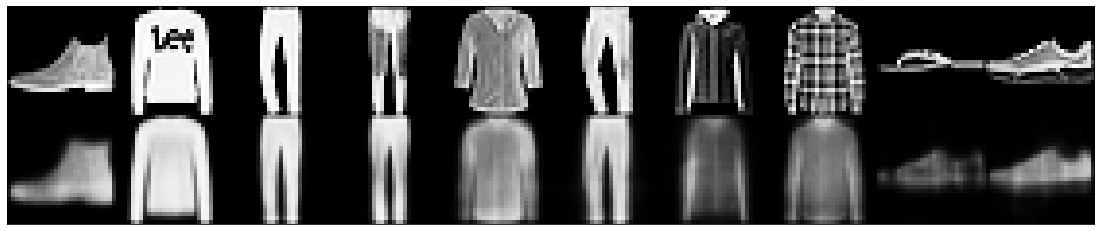

In [77]:
pred = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
plot_digits(imgs[:n_compare], pred[:n_compare])

## Результат обучения

In [0]:
def transfer_style(model, X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl = lbl_in
        lbl_in = np.zeros((rows, 10))
        lbl_in[:, lbl] = 1
    if isinstance(lbl_out, int):
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10))
        lbl_out[:, lbl] = 1
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out])

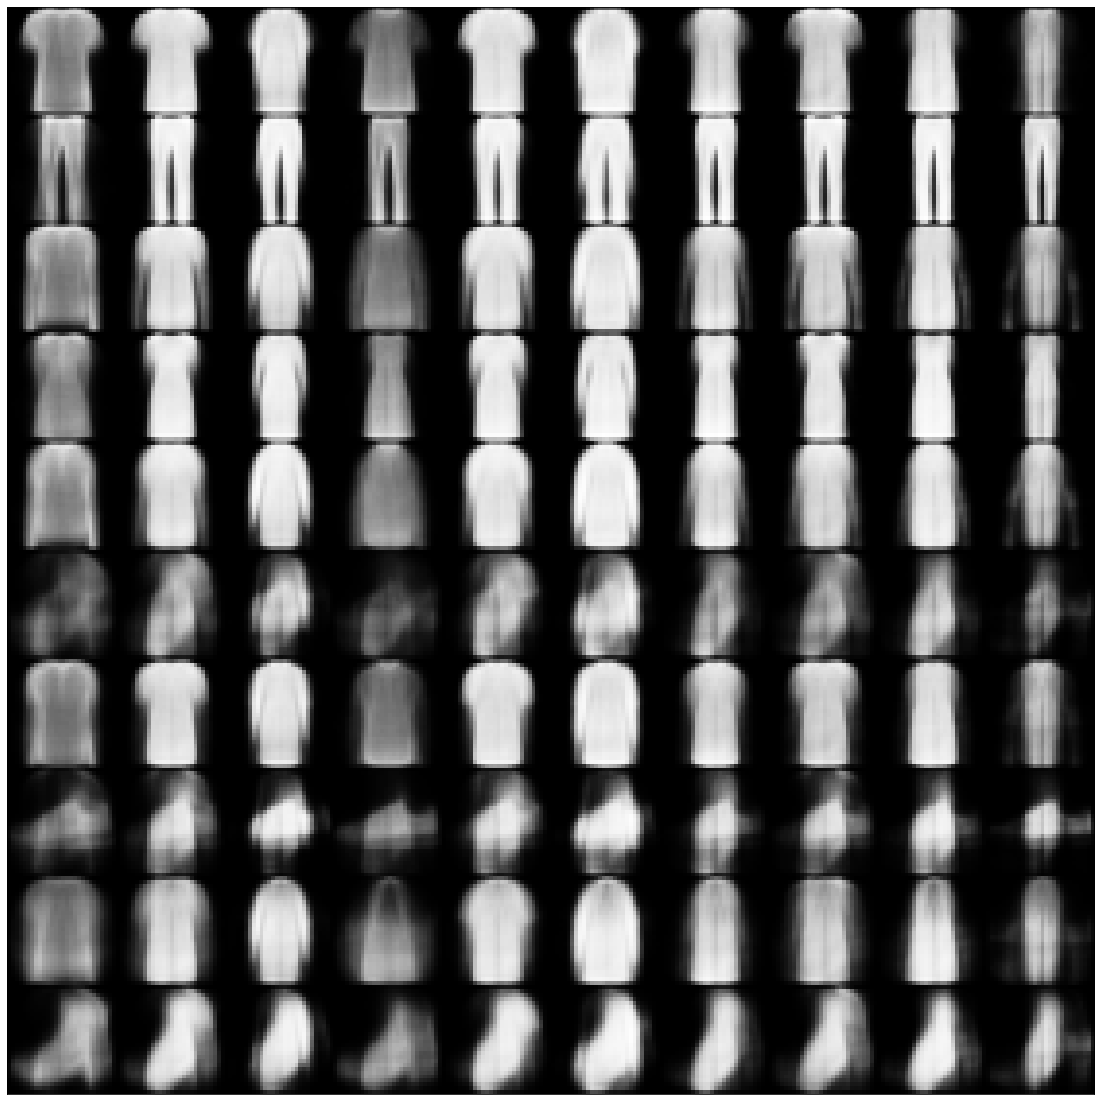

In [81]:
n = 10
lbl = 3
generated = []
prot = X_train[y_train == lbl][:n]

for i in range(num_classes):
    generated.append(transfer_style(transformator, prot, lbl, i))

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True)

## Сравнение работы автокодировщиков с разным размером скрытого пространства

In [72]:
# latent_dims = [2, 8, 32, 100, 200, 500, 700, 1000]
latent_dims = [24, 50, 64, 72]
cvaes = []
for dim in latent_dims:
    print("**** Latent %s ****" % dim)
    v = create_cvae(dim)
    
    v.fit(x = [X_train, y_train_cat, y_train_cat], 
             y = X_train, 
             shuffle = True, 
             epochs = 10,
             batch_size = batch_size,
             validation_data = ([X_test, y_test_cat, y_test_cat], X_test),
#              callbacks = model_callbacks,
             verbose=1)
    cvaes.append(v)
    


**** Latent 24 ****
Sampling: [[<tf.Tensor 'dense_302/BiasAdd:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'dense_303/BiasAdd:0' shape=(?, 24) dtype=float32>]]
Sampling: [[<tf.Tensor 'Encoder_60/dense_302/BiasAdd:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'Encoder_60/dense_303/BiasAdd:0' shape=(?, 24) dtype=float32>]]
(500, 24)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 346us/step - loss: 0.2779 - val_loss: 0.1879
Epoch 2/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1832 - val_loss: 0.1737
Epoch 3/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.1739 - val_loss: 0.1703
Epoch 4/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.1696 - val_loss: 0.1674
Epoch 5/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.1671 - val_loss: 0.1643
Epoch 6/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.1655 - val_l

Latent 24


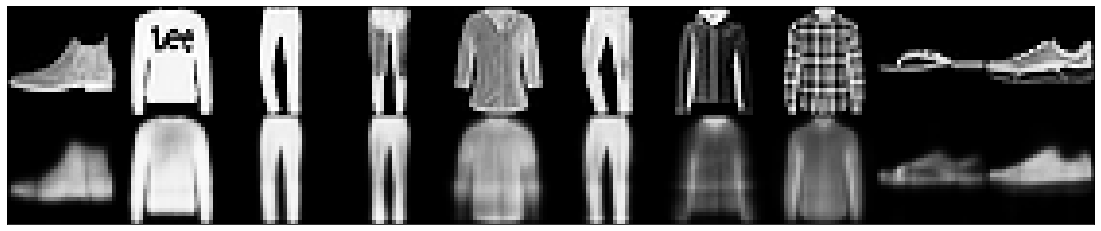

Latent 50


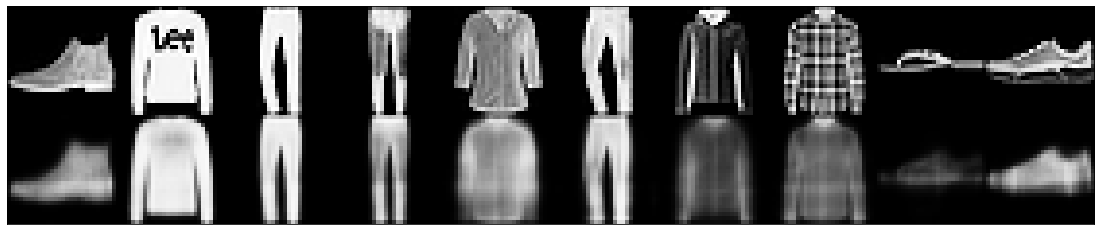

Latent 64


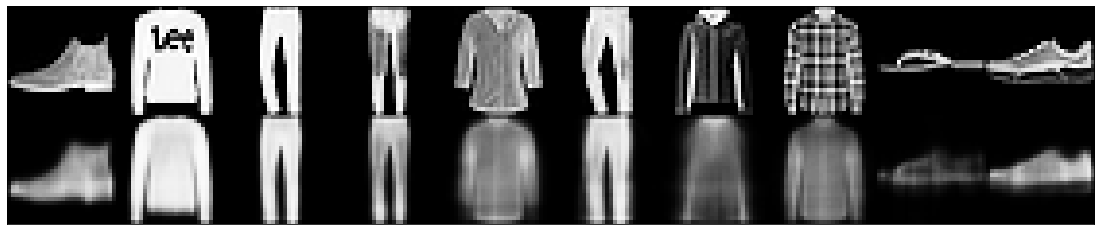

Latent 72


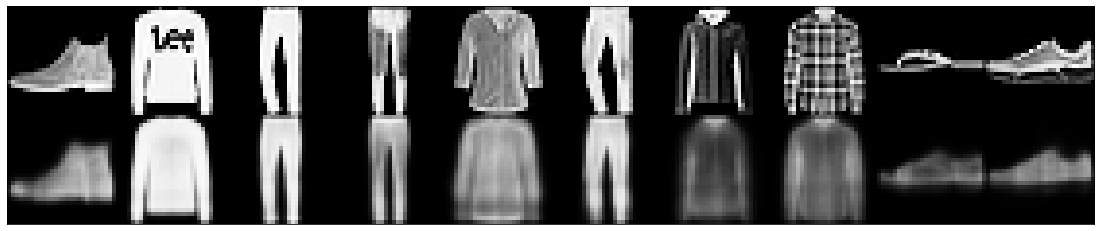

In [73]:
i = 0
for i in range(len(latent_dims)):
    print("Latent %s" % latent_dims[i])
    ae = cvaes[i]
    pred = ae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
    plot_digits(imgs[:n_compare], pred[:n_compare])
